## Import 

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import tensorflow as tf
import prepare_sub_image as ps
import cv2
import numpy as np
from skimage import measure
import PIL.Image as pilimg
import matplotlib.pyplot as plt
import math
from scipy import io

## Metrics

In [3]:
def ssim(target, ref):
    target_data = np.array(target)
    ref_data = np.array(ref)
    
    (score, diff) = measure.compare_ssim(target_data, ref_data, full = True, multichannel=True)
    
    return score

def psnr(target, ref):
    
    target_data = np.array(target, dtype = float)
    ref_data = np.array(ref, dtype = float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff**2))
    
    return 20 * math.log10(255/rmse)

## model

In [4]:
rgb_mean = np.array([0.4488, 0.4371, 0.4040])


def res_block(x, filters, i):
    
    input_img = x
    
    x = layers.Conv2D(filters = filters, kernel_size = 3, padding = 'same',
                      bias_initializer = 'zeros', name = 'Conv1_resi_{}'.format(i))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters = filters, kernel_size = 3, padding = 'same', 
                       bias_initializer = 'zeros', name = 'Conv2_resi_{}'.format(i))(x)
    
    if filters == 256:
        res_scale = 0.1
    else:
        res_scale = 1.0
        
    x = layers.Lambda(lambda x: x * res_scale)(x)
    
    x = layers.add([x, input_img])
    
    
    return x

    
def EDSR(scale, input_image, n_feats, n_resblocks):
    
    input_img = input_image
    x = layers.Lambda(lambda x: (x - rgb_mean))(input_image)
    
    x = layers.Conv2D(filters = n_feats, kernel_size = (3,3), padding = 'same', 
                         bias_initializer = 'zeros', name = 'Conv_out_1')(x)
    x_Conv1 = x
    
    for i in range(n_resblocks):
        x = res_block(x = x, filters = n_feats, i = i)
    
    x = layers.Conv2D(filters = n_feats, kernel_size = (3,3), padding = 'same', 
                         bias_initializer = 'zeros', name = 'Conv_out_2')(x)
    x = layers.add([x_Conv1, x])
    
    x = layers.Conv2D(filters = n_feats * (scale ** 2), kernel_size = (3,3), padding = 'same',
                     bias_initializer = 'zeros')(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale))(x)
    x = layers.Conv2D(filters = 3, kernel_size = (3,3), padding = 'same',
                        bias_initializer = 'zeros', name = 'Conv_out_3')(x)
    
    x = layers.Lambda(lambda x: x + rgb_mean)(x)
    
    EDSR = Model(inputs = input_img, outputs = x)
    
    EDSR.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mean_absolute_error', metrics = ['mean_absolute_error'])
    
    return EDSR

## Train & Predict 

In [9]:
scale = 3
test_set = 'DIV2K_validation'
conv_side = 8

def train():
    
    in1 = layers.Input(shape = (None, None, 3))
    edsr_model = EDSR(scale = scale, input_image = in1, n_feats = 64, n_resblocks = 16)
    
    print(edsr_model.summary())
    
    edsr_model.load_weights('checkpoint/EDSR_checkpoint_baseline_scale3.h5')
    #edsr_model.load_weights('checkpoint/EDSR_checkpoint_baseline_scale2_pre_2.h5', by_name = True)
    
    '''
    data, label = ps.read_training_data('training_sample/train_DIV2Kaug_scale3_2.h5')
    val_data, val_label = ps.read_training_data('training_sample/cross_val_DIV2K_scale3.h5')
    '''
    
    PATH_image = '../Dataset/test/test_mat/{}/scale{}/'.format(test_set, scale)
    IMAGE_PATH = 'output_image/{}/scale{}'.format(test_set, scale)
    
    names_image = os.listdir(PATH_image)
    names_image = sorted(names_image)
    
    nums = len(names_image)
    
    
    count = 0
    
    checkpoint_filepath = 'checkpoint/EDSR_checkpoint_baseline_scale3.h5'
    checkpoint_callbacks = [ModelCheckpoint(filepath = checkpoint_filepath, monitor = 'val_loss', verbose = 1, mode = 'min', 
                                            save_best_only = True), 
                            TensorBoard(log_dir = './logs', update_freq = 'epoch', histogram_freq = 1, write_graph = True, 
                                        write_images = True)]
    
    for i in range(0, 1):
        '''
        edsr_model.fit(x = data, y = label, batch_size = 16, epochs = 2, verbose = 1,
                       callbacks = checkpoint_callbacks, validation_data = (val_data, val_label), shuffle = True)
        
        edsr_model.save('model_weight/EDSR_baseline_scale3.h5')
        '''
        
        count += 1
        
        psnr_edsr = []
        psnr_bicubic = []
        ssim_edsr = []
        ssim_bicubic = []
        
        for i in range(nums):
            
            mat_image = io.loadmat(PATH_image + names_image[i])
            
            hr_img = mat_image['im_hr_rgb']
            bicubic_img = mat_image['im_bicubic_rgb']
            lr_img = mat_image['im_lr_rgb']
            
            INPUT_NAME = IMAGE_PATH + '/' + 'input{}.jpg'.format(i)
            OUTPUT_NAME = IMAGE_PATH + '/' + 'predict{}.jpg'.format(i)
            
            input_shape = lr_img.shape
            
            input_RGB = np.zeros([1, input_shape[0], input_shape[1], 3])
            input_RGB[0, :, :, :] = lr_img / 255
                
            pre = edsr_model.predict(input_RGB, batch_size = 1)
            pre = pre * 255
            pre[pre[:] > 255] = 255
            pre[pre[:] < 0] = 0            
            
            output_shape = hr_img.shape
            
            # python은 RGB가 아니라 BGR이 default이기 때문
            output_img = np.zeros([output_shape[0], output_shape[1], 3])
            output_img[:, :, 2] = pre[0, :, :, 0]
            output_img[:, :, 1] = pre[0, :, :, 1]
            output_img[:, :, 0] = pre[0, :, :, 2]
            
            cv2.imwrite(OUTPUT_NAME, output_img)
            
            hr_img_r = hr_img[:, :, 0]
            hr_img_g = hr_img[:, :, 1]
            hr_img_b = hr_img[:, :, 2]

            bicubic_img_r = bicubic_img[:, :, 0]
            bicubic_img_g = bicubic_img[:, :, 1]
            bicubic_img_b = bicubic_img[:, :, 2]
            
            # 조심 (위에서 output에 RGB가 아니라 BGR 순서대로 넣었다.)
            output_img_r = output_img[:, :, 2]
            output_img_g = output_img[:, :, 1]
            output_img_b = output_img[:, :, 0]

            hr_img_Y = 16 + (65.738 * hr_img_r + 129.057 * hr_img_g + 25.064 * hr_img_b) / 255
            bicubic_img_Y = 16 + (65.738 * bicubic_img_r + 129.057 * bicubic_img_g + 25.064 * bicubic_img_b) / 255
            output_img_Y = 16 + (65.738 * output_img_r + 129.057 * output_img_g + 25.064 * output_img_b) / 255
                
            
            hr_img_measure = hr_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            bicubic_img_measure = bicubic_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            output_img_measure = output_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            
            
            psnr_bicubic_one = psnr(bicubic_img_measure, hr_img_measure)
            psnr_edsr_one = psnr(output_img_measure, hr_img_measure)
            
            ssim_bicubic_one = ssim(bicubic_img_measure, hr_img_measure)
            ssim_edsr_one = ssim(output_img_measure, hr_img_measure)
            
            print(i + 1)
            print('BICUBIC: ', psnr_bicubic_one, 'ssim: ', ssim_bicubic_one)
            print('EDSR: ', psnr_edsr_one, 'ssim: ', ssim_edsr_one)
            
            psnr_bicubic.append(psnr_bicubic_one)
            ssim_bicubic.append(ssim_bicubic_one)
            
            psnr_edsr.append(psnr_edsr_one)
            ssim_edsr.append(ssim_edsr_one)
            
            
        psnr_bicubic_final = np.mean(psnr_bicubic)
        ssim_bicubic_final = np.mean(ssim_bicubic)
        
        psnr_edsr_final = np.mean(psnr_edsr)
        ssim_edsr_final = np.mean(ssim_edsr)
        
        print('Epochs: ', count)
        
        print('Bicubic')
        print('PSNR: ', psnr_bicubic_final, 'SSIM: ', ssim_bicubic_final)
        print('EDSR')
        print('PSNR: ', psnr_edsr_final, 'SSIM: ', ssim_edsr_final)
    
    
    
if __name__ == '__main__':
    
    train()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_76 (Lambda)              (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv_out_1 (Conv2D)             (None, None, None, 6 1792        lambda_76[0][0]                  
__________________________________________________________________________________________________
Conv1_resi_0 (Conv2D)           (None, None, None, 6 36928       Conv_out_1[0][0]                 
____________________________________________________________________________________________

1
BICUBIC:  30.95547856416784 ssim:  0.7175631633621627
EDSR:  33.110816931567356 ssim:  0.7938015278633919
2
BICUBIC:  28.292292922066565 ssim:  0.46508994749153637
EDSR:  29.76636688740685 ssim:  0.5613480796591441
3
BICUBIC:  27.07329195732465 ssim:  0.4736511588262368
EDSR:  31.56100337254978 ssim:  0.5592666044580056
4
BICUBIC:  30.678343618411738 ssim:  0.5744199748791219
EDSR:  31.964362520930813 ssim:  0.6471827929140133
5
BICUBIC:  28.445236551243628 ssim:  0.4477795342290804
EDSR:  30.72288606351075 ssim:  0.5418869255578691
6
BICUBIC:  31.953270452108722 ssim:  0.5197550821412861
EDSR:  34.64177945118774 ssim:  0.5630184820077001
7
BICUBIC:  29.381875933322192 ssim:  0.3621771915925758
EDSR:  31.619315081601485 ssim:  0.4239616028330484
8
BICUBIC:  35.735506110729524 ssim:  0.6579406900967169
EDSR:  38.352143458352735 ssim:  0.7016305945745865
9
BICUBIC:  32.626510694360654 ssim:  0.48115734145066386
EDSR:  34.79651197040895 ssim:  0.5628569195379707
10
BICUBIC:  33.52177683

77
BICUBIC:  32.29444634854042 ssim:  0.6098487318081238
EDSR:  36.24197441936916 ssim:  0.692236295891924
78
BICUBIC:  28.118180650853013 ssim:  0.336494052677718
EDSR:  30.368642223370664 ssim:  0.42907384304123325
79
BICUBIC:  27.913586219847232 ssim:  0.45626017209935815
EDSR:  29.343954231007558 ssim:  0.5201183100142998
80
BICUBIC:  33.73807636455102 ssim:  0.39287534021396425
EDSR:  35.60727683161436 ssim:  0.4525169956672942
81
BICUBIC:  27.425092075207118 ssim:  0.489128618588443
EDSR:  28.816475332512844 ssim:  0.5545750660684666
82
BICUBIC:  34.6310104027482 ssim:  0.6159577411513029
EDSR:  37.07870680659658 ssim:  0.6538022566695537
83
BICUBIC:  28.73752413984949 ssim:  0.5778440607821234
EDSR:  30.98951991151238 ssim:  0.6903208153761841
84
BICUBIC:  27.240936392053484 ssim:  0.5049353390989054
EDSR:  29.624656704023657 ssim:  0.6271708131142784
85
BICUBIC:  24.24468593948649 ssim:  0.3497746544211721
EDSR:  25.474406659435935 ssim:  0.45720004054577973
86
BICUBIC:  37.473

## Visualization

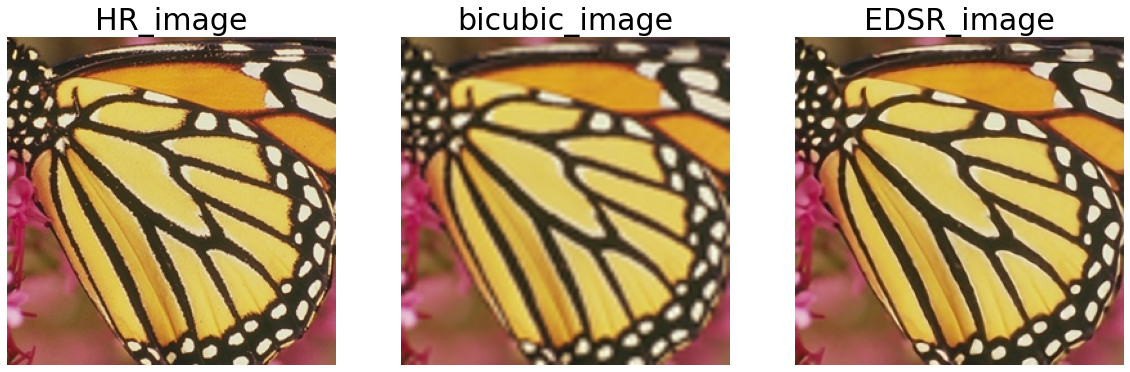

In [7]:
def visualization():
    
    hr_img = pilimg.open('test_sample/test_image/{}/hr_ground/butterfly_GT.bmp'.format(test_set))
    pix_hr = np.array(hr_img)
    
    bicubic_img = pilimg.open('test_sample/test_image/{}/bicubic_rgb/scale{}/bicubic_RGB_{}_3.bmp'.format(test_set, scale, scale))
    pix_bicubic = np.array(bicubic_img)
    
    edsr_img = pilimg.open('output_image/{}/scale{}/predict2.jpg'.format(test_set, scale))
    pix_edsr = np.array(edsr_img)
    
    fig = plt.figure(figsize = (20,32))
    rows = 1
    cols = 3
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(hr_img)
    ax1.set_title('HR_image', size = 30)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(bicubic_img)
    ax2.set_title('bicubic_image', size = 30)
    ax2.axis('off')
    
    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(edsr_img)
    ax3.set_title('EDSR_image', size = 30)
    ax3.axis('off')
    
    plt.show()
    
    
if __name__ == '__main__':
    
    visualization()

In [ ]:
checkpoint/EDSR_checkpoint_baseline_scale3_pre_2.h5
Set5
1
BICUBIC:  33.83356170608685 ssim:  0.6304123449209844
EDSR:  35.53522676178567 ssim:  0.6921972652911709

Set14
1
BICUBIC:  23.17085387286571 ssim:  0.3192125762134446
EDSR:  23.9665273599504 ssim:  0.42448111440447217

B100
1
BICUBIC:  24.093875574683516 ssim:  0.3510172510786736
EDSR:  25.138773144257172 ssim:  0.4292251989585742


Urban100
1
BICUBIC:  26.12676388982239 ssim:  0.34876363692833495
EDSR:  29.249094562013976 ssim:  0.4677971441882868

DIV2K_validation


In [ ]:
checkpoint/EDSR_checkpoint_baseline_scale3_pre.h5

1
BICUBIC:  33.83356170608685 ssim:  0.6304123449209844
EDSR:  35.53765060706746 ssim:  0.6911556915590313
2
BICUBIC:  32.62611730021694 ssim:  0.7321724382954554
EDSR:  37.90995075541676 ssim:  0.8015260943138477
3
BICUBIC:  24.057971580689404 ssim:  0.48559516058278385
EDSR:  30.641311129991283 ssim:  0.6741193268817124
4
BICUBIC:  32.775148455788226 ssim:  0.4453477982262936
EDSR:  33.99272769973786 ssim:  0.49828809368526367
5
BICUBIC:  28.676734150391358 ssim:  0.627546884630007
EDSR:  32.72502255434618 ssim:  0.7114089224418044
Epochs:  1
Bicubic
PSNR:  30.393906638634558 SSIM:  0.5842149253311048
EDSR
PSNR:  34.16133254931191 SSIM:  0.6752996257763318
        
        
        
checkpoint/EDSR_checkpoint_baseline_scale3_pre_2.h5
1
BICUBIC:  33.83356170608685 ssim:  0.6304123449209844
EDSR:  35.53522676178567 ssim:  0.6921972652911709
2
BICUBIC:  32.62611730021694 ssim:  0.7321724382954554
EDSR:  37.924547983088864 ssim:  0.8027217410865346
3
BICUBIC:  24.057971580689404 ssim:  0.48559516058278385
EDSR:  30.57177101425562 ssim:  0.6721103097958463
4
BICUBIC:  32.775148455788226 ssim:  0.4453477982262936
EDSR:  34.00186277287757 ssim:  0.4992278640061219
5
BICUBIC:  28.676734150391358 ssim:  0.627546884630007
EDSR:  32.76035110729355 ssim:  0.7132244702601204
Epochs:  1
Bicubic
PSNR:  30.393906638634558 SSIM:  0.5842149253311048
EDSR
PSNR:  34.15875192786026 SSIM:  0.6758963300879588